In [45]:
from torchvision import datasets , transforms
from torch.utils.data import Dataset , DataLoader , random_split
from torchsummary import summary
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import seaborn as sns
import cv2

In [46]:
imagepath = './week4/train/'
csvfile = './week4/mnist.train.map.csv'

In [47]:
df = pd.read_csv(csvfile)
df

,id,category
0,75606737-d17d-43eb-86e6-6735b6f45a52.png,8
1,800e3baf-9ab1-48c0-a9ce-46c5fac9ff69.png,1
2,c40b7fc4-07f1-4c78-abac-121bde38e267.png,0
3,1b2e1b3d-46f2-4c3f-b741-a8d5099ce710.png,4
4,b8fd3385-9403-48a4-9d9e-74bde635e688.png,9
...,...,...
8250,9b2af0fb-f1be-4782-a614-23fa59a366d7.png,8
8251,ca58239a-7a35-4c96-9b6a-451e112dc5da.png,6
8252,4ec2ba63-0845-4812-a3fa-1f5eda80de8e.png,8
8253,8479e8d8-d592-4931-926c-17a84b02ad0a.png,2


<AxesSubplot:xlabel='category', ylabel='count'>

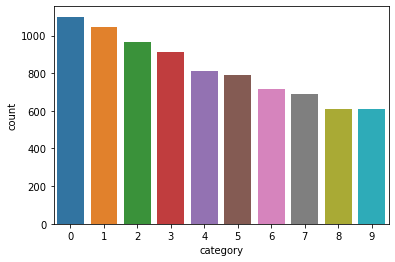

In [48]:
sns.countplot('category',data=df)

In [49]:
### Crop whitespace of image
### from [620x620] to [64x64]

def preproces_image(image,*,kernel_size=15,crop_side=50,blocksize=35,constant=15,max_value=255):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    bit = cv2.bitwise_not(gray)
    image_adapted = cv2.adaptiveThreshold(
        src=bit,
        maxValue=max_value,
        adaptiveMethod=cv2.ADAPTIVE_THRESH_MEAN_C,
        thresholdType=cv2.THRESH_BINARY,
        blockSize=blocksize,
        C=constant,
    )
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    erosion = cv2.erode(image_adapted, kernel, iterations=2)
    return erosion[crop_side:-crop_side, crop_side:-crop_side]

def find_edges(image_preprocessed, *, bw_threshold=150, limits=(0.0, 0.0)):
    mask = image_preprocessed < bw_threshold
    edges = []
    for axis in (1, 0):
        count = mask.sum(axis=axis)
        limit = limits[axis] * image_preprocessed.shape[axis]  
        index_ = np.where(count >= limit)      
        _min, _max = index_[0][0], index_[0][-1]
        edges.append((_min, _max))
        #edges.append((620, 620))
    return edges

def adapt_edges(edges, *, height, width):
    (x_min, x_max), (y_min, y_max) = edges
    x_min2 = x_min
    x_max2 = x_max + min(240, (height - x_max) * 5 // 11)
    # could do with less magic numbers
    y_min2 = max(0, y_min)
    y_max2 = y_max + min(240, (width - y_max) * 5 // 11)
    return (x_min2, x_max2), (y_min2, y_max2)

def crop_image(im):
    height, width, c   = im.shape
    image_preprocessed = preproces_image(im)
    edges = find_edges(image_preprocessed)
    (x_min, x_max), (y_min, y_max) = adapt_edges(
        edges, height=height, width=width
    )
    return im[x_min:x_max, y_min:y_max]

#def resize_image(im, h=64, w=64):
#    return cv2.resize(cropped, (h, w))

In [50]:
t = imagepath + df['id'][24]
print(t)

./week4/train/59937745-b5e4-4f69-aee6-3e43a1381846.png


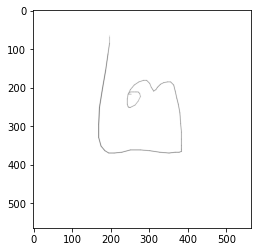

In [51]:
im      = cv2.imread(t)
output = crop_image(im)
h, w, c = output.shape
plt.imshow(output)

In [52]:
batch = 24
nkresize = 300

In [53]:
nkclassification = 10 # 10 Thai-Mnist Class
dstransform = transforms.Compose([
    transforms.Resize((nkresize,nkresize)),
    transforms.RandomRotation((-5,5)),
    transforms.ToTensor()])
    #transforms.ColorJitter(brightness=1,contrast=1,saturation=1,hue=0.5),
    #transforms.RandomGrayscale(0.25),
    #transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.25,0.25,0.25))])

In [54]:
class NKLoadDataset(Dataset):
    def __init__(self,image_dir, csv_all,transform=None):
        self.t = transform
        self.x_path = image_dir
        self.y_class = None
        df = pd.read_csv(csv_all)
        #X_name คือ column name ของ Dataframe
        self.x_name = df['id'].values
        self.y_class = df['category'].values     

    def __len__(self):
        return len(self.y_class)

    def __getitem__(self, idx):
        #image = Image.open(self.x_path + self.x_name[idx])
        im = cv2.imread(self.x_path + self.x_name[idx])
        im2 = crop_image(im)
        image = Image.fromarray(im2)
        return self.t(image),self.y_class[idx] 

In [55]:
nktest  = NKLoadDataset(image_dir=imagepath,csv_all=csvfile,transform=dstransform)

In [56]:
nktest[0][0].shape

torch.Size([3, 300, 300])

In [57]:
trainds1 , validds1 = random_split(nktest,[int(round(len(nktest)*0.7)),int(round(len(nktest)*0.3))+1])

In [58]:
trainds1 , validds1 = random_split(nktest,[int(round(len(nktest)*0.7)),int(round(len(nktest)*0.3))+1])
traindl1 = DataLoader(trainds1,batch,shuffle = True,pin_memory=True)
validdl1 = DataLoader(validds1,batch,shuffle = True,pin_memory=True)

In [59]:
transfer_model = models.resnet18(pretrained=True)

In [60]:
transfer_model.fc = nn.Sequential(nn.Linear(transfer_model.fc.in_features,500),
nn.ReLU(),                                 
nn.Dropout(), nn.Linear(500,10)) 

In [61]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    device = torch.device("cuda")
    print("Using GPU : ",torch.cuda.get_device_name(0))
    #print(torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")


NK_Checkpoint = "./tmp/checkpoint.pkl"
result_file = os.path.isfile('./tmp/checkpoint.pkl')

Using GPU :  GeForce RTX 2060


In [62]:
if result_file == True:
    nk_state_dict = torch.load(NK_Checkpoint)
    transfer_model.load_state_dict(nk_state_dict)
    print("Load last model parameters")
optimizer = optim.Adam(transfer_model.parameters(), lr=0.00001)

transfer_model.to(device)

Load last model parameters


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [63]:
def check_cuda_using():
    if device.type == 'cuda':
        #print(torch.cuda.get_device_name(0))
        #print('Memory Usage:')
        #print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
        #print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')
        print('Memory Usage:Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB''Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

In [64]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    print("Start Running (Please Wait!)")
    for epoch in range(epochs):
        training_loss = 0.0
        valid_loss = 0.0
        #check_cuda_using()
        model.train()
        #print("Start Training : epoch =  " , epoch , "Dataloader length = ",len(train_loader))
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        #print("Start Evaluation : epoch = " , epoch, "Dataloader length = ",len(val_loader))
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f} %'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples*100))

In [65]:
train(transfer_model, optimizer,torch.nn.CrossEntropyLoss(), traindl1,validdl1, epochs=1, device=device)
torch.save(transfer_model.state_dict(),NK_Checkpoint)
print("Finish Computation!")
summary(transfer_model,input_size=(3,nkresize,nkresize))

Start Running (Please Wait!)
Epoch: 0, Training Loss: 0.01, Validation Loss: 0.00, accuracy = 100.00 %
Finish Computation!
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]           9,408
       BatchNorm2d-2         [-1, 64, 150, 150]             128
              ReLU-3         [-1, 64, 150, 150]               0
         MaxPool2d-4           [-1, 64, 75, 75]               0
            Conv2d-5           [-1, 64, 75, 75]          36,864
       BatchNorm2d-6           [-1, 64, 75, 75]             128
              ReLU-7           [-1, 64, 75, 75]               0
            Conv2d-8           [-1, 64, 75, 75]          36,864
       BatchNorm2d-9           [-1, 64, 75, 75]             128
             ReLU-10           [-1, 64, 75, 75]               0
       BasicBlock-11           [-1, 64, 75, 75]               0
           Conv2d-12           [-1, 64, 75, 

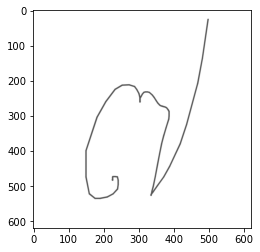

In [66]:
imgpath = './week4/train/'
pictures = 'f0eba571-de51-485d-8cef-6b9a1d7af24f' +'.png'
picturetest = imgpath  + pictures
img = Image.open(picturetest)
plt.imshow(img)

In [67]:
def nkfindnumber(path,imgn): 
    labels = ['0','1','2','3','4','5','6','7','8','9']
    img = cv2.imread(path + imgn)
    img2 = crop_image(img)
    img3 = Image.fromarray(img2)
    img3 = dstransform(img3)
    img4 = img3.unsqueeze(0)
    img4 = img4.to(device)
    prediction = F.softmax(transfer_model(img4))
    prediction = prediction.argmax()
    return labels[prediction] 

In [68]:
print(nkfindnumber(imgpath,pictures))

7


In [69]:
pathrule = './week4/'
df1 = pd.read_csv(pathrule + 'train.rules' +'.csv')
df1.head()

,id,feature1,feature2,feature3,predict
0,7c5fda39-c4a6-4d49-a0f6-751c7cd72bb4,NaN,75606737-d17d-43eb-86e6-6735b6f45a52.png,800e3baf-9ab1-48c0-a9ce-46c5fac9ff69.png,9
1,7e15ec1b-fe36-4a9e-a1cd-7c160e6a1b9c,NaN,75606737-d17d-43eb-86e6-6735b6f45a52.png,800e3baf-9ab1-48c0-a9ce-46c5fac9ff69.png,9
2,96b5d8b6-61cd-49f2-b22f-16fe25483cbc,NaN,75606737-d17d-43eb-86e6-6735b6f45a52.png,800e3baf-9ab1-48c0-a9ce-46c5fac9ff69.png,9
3,84ce5493-7e0f-4aee-8bb7-f799d714b5b3,NaN,c40b7fc4-07f1-4c78-abac-121bde38e267.png,1b2e1b3d-46f2-4c3f-b741-a8d5099ce710.png,4
4,7cb117e7-d8f3-400b-aeb3-a84fa3fb54e8,NaN,c40b7fc4-07f1-4c78-abac-121bde38e267.png,1b2e1b3d-46f2-4c3f-b741-a8d5099ce710.png,4


In [70]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5555 entries, 0 to 5554
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        5555 non-null   object
 1   feature1  5271 non-null   object
 2   feature2  5555 non-null   object
 3   feature3  5555 non-null   object
 4   predict   5555 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 217.1+ KB


In [71]:
df1['feature1_value'] = ""
df1['feature2_value'] = ""
df1['feature3_value'] = ""
df1.head()

,id,feature1,feature2,feature3,predict,feature1_value,feature2_value,feature3_value
0,7c5fda39-c4a6-4d49-a0f6-751c7cd72bb4,NaN,75606737-d17d-43eb-86e6-6735b6f45a52.png,800e3baf-9ab1-48c0-a9ce-46c5fac9ff69.png,9,,,
1,7e15ec1b-fe36-4a9e-a1cd-7c160e6a1b9c,NaN,75606737-d17d-43eb-86e6-6735b6f45a52.png,800e3baf-9ab1-48c0-a9ce-46c5fac9ff69.png,9,,,
2,96b5d8b6-61cd-49f2-b22f-16fe25483cbc,NaN,75606737-d17d-43eb-86e6-6735b6f45a52.png,800e3baf-9ab1-48c0-a9ce-46c5fac9ff69.png,9,,,
3,84ce5493-7e0f-4aee-8bb7-f799d714b5b3,NaN,c40b7fc4-07f1-4c78-abac-121bde38e267.png,1b2e1b3d-46f2-4c3f-b741-a8d5099ce710.png,4,,,
4,7cb117e7-d8f3-400b-aeb3-a84fa3fb54e8,NaN,c40b7fc4-07f1-4c78-abac-121bde38e267.png,1b2e1b3d-46f2-4c3f-b741-a8d5099ce710.png,4,,,


In [ ]:
# BE CARE FULL CAUSE OF 2X,XXXX RECORDS
# TOOOOOO LONG TIMEEEEEEEEEEEEEEE

imgtrainpath = './week4/train/'
for r in range(len(df1)):
    print('================================')
    for c in range(4):
        if not (c == 0): # ไม่รวมคอลัมภ์แรก
             if pd.notnull(df1.iloc[r,c]):
                 print(df1.iloc[r,c])
                 df1.iloc[r,c+4] = nkfindnumber(imgtrainpath,df1.iloc[r,c])
                 print(df1.iloc[r,c+4])

In [ ]:
df1.sample(10)

In [72]:
df1.to_csv('./week4/NKFindnumber.csv')

In [74]:
df2 = pd.read_csv('./week4/NKFindnumber.csv')

In [75]:
df2

,Unnamed: 0,id,feature1,feature2,feature3,predict,feature1_value,feature2_value,feature3_value
0,0,7c5fda39-c4a6-4d49-a0f6-751c7cd72bb4,NaN,75606737-d17d-43eb-86e6-6735b6f45a52.png,800e3baf-9ab1-48c0-a9ce-46c5fac9ff69.png,9,NaN,8,1
1,1,7e15ec1b-fe36-4a9e-a1cd-7c160e6a1b9c,NaN,75606737-d17d-43eb-86e6-6735b6f45a52.png,800e3baf-9ab1-48c0-a9ce-46c5fac9ff69.png,9,NaN,8,1
2,2,96b5d8b6-61cd-49f2-b22f-16fe25483cbc,NaN,75606737-d17d-43eb-86e6-6735b6f45a52.png,800e3baf-9ab1-48c0-a9ce-46c5fac9ff69.png,9,NaN,8,1
3,3,84ce5493-7e0f-4aee-8bb7-f799d714b5b3,NaN,c40b7fc4-07f1-4c78-abac-121bde38e267.png,1b2e1b3d-46f2-4c3f-b741-a8d5099ce710.png,4,NaN,0,4
4,4,7cb117e7-d8f3-400b-aeb3-a84fa3fb54e8,NaN,c40b7fc4-07f1-4c78-abac-121bde38e267.png,1b2e1b3d-46f2-4c3f-b741-a8d5099ce710.png,4,NaN,0,4
...,...,...,...,...,...,...,...,...,...
5550,5550,769b31a2-cb7e-4a89-89d6-efed3199872e,0c754c5d-4166-433e-ac4d-4d1c7ef8e30a.png,bee226cb-6fbf-4470-b2de-d98e5af6110a.png,8801b5ff-821c-477e-9ce7-f65199f75646.png,0,7.0,3,6
5551,5551,9f603c3a-4475-4d4b-a3ee-e8f868979749,787e9fe5-cb37-4cc5-afbb-20351616ff71.png,90ef2abe-439b-4655-a932-5a8ca5a91b71.png,c39f05cf-17aa-4b7d-afd3-29667f039216.png,51,9.0,1,7
5552,5552,f25bbfff-6fd9-41f5-b2c2-0059b1a76bc6,a8c56afb-35cf-473a-bcd9-0927f8b6994b.png,7d15bcf1-5141-480c-9265-70a74aa2ed27.png,8f9eba51-8123-4186-8b11-8d2d2d9d134a.png,55,7.0,1,5
5553,5553,e550dbb5-5127-4828-ac5b-153e9229992e,70ffaa6c-25a1-435a-8413-a8ad26fc8d7d.png,9b2af0fb-f1be-4782-a614-23fa59a366d7.png,ca58239a-7a35-4c96-9b6a-451e112dc5da.png,67,8.0,8,6


In [76]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5555 entries, 0 to 5554
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      5555 non-null   int64  
 1   id              5555 non-null   object 
 2   feature1        5271 non-null   object 
 3   feature2        5555 non-null   object 
 4   feature3        5555 non-null   object 
 5   predict         5555 non-null   int64  
 6   feature1_value  5271 non-null   float64
 7   feature2_value  5555 non-null   int64  
 8   feature3_value  5555 non-null   int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 390.7+ KB


In [77]:
df2['feature1_value'] = df2['feature1_value'].fillna(-1)

In [78]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5555 entries, 0 to 5554
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      5555 non-null   int64  
 1   id              5555 non-null   object 
 2   feature1        5271 non-null   object 
 3   feature2        5555 non-null   object 
 4   feature3        5555 non-null   object 
 5   predict         5555 non-null   int64  
 6   feature1_value  5555 non-null   float64
 7   feature2_value  5555 non-null   int64  
 8   feature3_value  5555 non-null   int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 390.7+ KB


In [79]:
df2['feature1_value'] = df2['feature1_value'].astype('int64')

In [80]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5555 entries, 0 to 5554
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      5555 non-null   int64 
 1   id              5555 non-null   object
 2   feature1        5271 non-null   object
 3   feature2        5555 non-null   object
 4   feature3        5555 non-null   object
 5   predict         5555 non-null   int64 
 6   feature1_value  5555 non-null   int64 
 7   feature2_value  5555 non-null   int64 
 8   feature3_value  5555 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 390.7+ KB


In [81]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold , cross_val_score
from sklearn.metrics import mean_absolute_error,r2_score

In [82]:
X = df2[['feature1_value','feature2_value','feature3_value']]
y = df2['predict']

In [83]:
model = LinearRegression()
cvs = cross_val_score(model,X/10,y/100,cv=10)
cvs

array([        nan,  0.30821219,  0.19493707,  0.17460895,  0.11416085,
        0.0824697 , -0.00739852,  0.01809283,  0.10816766,  0.07674783])

In [84]:
model.fit(X,y)
model.score(X,y)

0.16125932412613142

In [85]:
t = df2.iloc[0,6:].to_numpy().reshape(1,-1)
print(model.predict(t))

[13.00450785]


In [132]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn import linear_model
from sklearn.metrics import confusion_matrix , r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

In [ ]:
# Model 1: Linear SVC version
# Create a pipeline
clf_linSVC = Pipeline([
    ("linear_svc", LinearSVC(C=200, loss="hinge", max_iter=100000))
])

# Train the model
clf_linSVC.fit(X_train, y_train)

# Evaluate the model's accuracy
print("Train set accuracy = " + str(clf_linSVC.score(X_train, y_train)))
print("Test set accuracy = " + str(clf_linSVC.score(X_test, y_test)))

In [87]:
# Model 2: Gaussian RBF Kernel version
# Create a pipeline
clf_SVC = Pipeline([
    ("linear_svc", SVC(kernel="rbf", gamma=5, C=100, max_iter=1000000))
])

# Train the model
clf_SVC.fit(X_train, y_train)

# Evaluate the model's accuracy
print("Train set accuracy = " + str(clf_SVC.score(X_train, y_train)))
print("Test set accuracy = " + str(clf_SVC.score(X_test, y_test)))

Train set accuracy = 0.996656378600823
Test set accuracy = 0.9520095980803839


In [88]:
t = df2.iloc[678,6:].to_numpy().reshape(1,-1)
print(t)
print(clf_SVC.predict(t))

[[0 8 6]]
[48]


In [89]:
pathrule = './week4/'
df3 = pd.read_csv(pathrule + 'test.rules' +'.csv')
df3.head()

,id,feature1,feature2,feature3,predict
0,5339e74f-56f2-48f1-bab2-59d5f8aa030a,NaN,72f260fb-5e89-4f99-928a-5db931c4eb65.png,f30827c8-f17e-4ab4-b668-9cae733819cd.png,NaN
1,b4ed46c8-4bcb-46c9-b8af-f833d4351849,NaN,72f260fb-5e89-4f99-928a-5db931c4eb65.png,f30827c8-f17e-4ab4-b668-9cae733819cd.png,NaN
2,09a42f96-dd78-499c-9772-b4be5bbf04f7,NaN,5f463395-957b-4b0f-b813-0494d75fa70c.png,feaa5a12-222c-4912-b68a-c8e4c5437a62.png,NaN
3,baeeeb75-2845-4d33-a099-d0e32ec48078,NaN,c6d635e1-e60e-4ad0-949e-d50d0cbc09b7.png,469661c1-aea7-435e-be79-51882f790ccc.png,NaN
4,e1d1881e-6273-4225-b5ca-3b91d79fe626,NaN,d21ea15d-582f-473c-b319-b3907bbca405.png,c4359d1d-80fb-4aae-8b76-8bcaf043ee24.png,NaN


In [90]:
df3['feature1_value'] = ""
df3['feature2_value'] = ""
df3['feature3_value'] = ""
df3.head()

,id,feature1,feature2,feature3,predict,feature1_value,feature2_value,feature3_value
0,5339e74f-56f2-48f1-bab2-59d5f8aa030a,NaN,72f260fb-5e89-4f99-928a-5db931c4eb65.png,f30827c8-f17e-4ab4-b668-9cae733819cd.png,NaN,,,
1,b4ed46c8-4bcb-46c9-b8af-f833d4351849,NaN,72f260fb-5e89-4f99-928a-5db931c4eb65.png,f30827c8-f17e-4ab4-b668-9cae733819cd.png,NaN,,,
2,09a42f96-dd78-499c-9772-b4be5bbf04f7,NaN,5f463395-957b-4b0f-b813-0494d75fa70c.png,feaa5a12-222c-4912-b68a-c8e4c5437a62.png,NaN,,,
3,baeeeb75-2845-4d33-a099-d0e32ec48078,NaN,c6d635e1-e60e-4ad0-949e-d50d0cbc09b7.png,469661c1-aea7-435e-be79-51882f790ccc.png,NaN,,,
4,e1d1881e-6273-4225-b5ca-3b91d79fe626,NaN,d21ea15d-582f-473c-b319-b3907bbca405.png,c4359d1d-80fb-4aae-8b76-8bcaf043ee24.png,NaN,,,


In [91]:
# BE CARE FULL CAUSE OF 2X,XXXX RECORDS
# TOOOOOO LONG TIMEEEEEEEEEEEEEEE
imgtrainpath = './week4/test/'
for r in range(len(df3)):
    print('================================')
    for c in range(4):
        if not (c == 0): # ไม่รวมคอลัมภ์แรก
             if pd.notnull(df3.iloc[r,c]):
                 print(df3.iloc[r,c])
                 df3.iloc[r,c+4] = nkfindnumber(imgtrainpath,df3.iloc[r,c])
                 print(df3.iloc[r,c+4])

png
8
e9803574-57e0-4eb8-be1c-3d138a9b0377.png
8
e1ab2f16-e73d-442b-9c08-23f4f9ef9e9d.png
5
ad510dee-5d67-4d31-84ee-6e2738673beb.png
2
77334174-86f7-48d4-a6f2-a535e9ef2732.png
4
041804fe-6d71-47b1-9ee8-2af27123ef2c.png
4
8319c55d-8a46-4110-9f37-b737ca7a651f.png
0
917f5e4b-1017-4a71-a337-db43ea860e82.png
6
2135af4e-a762-4fe4-9af1-7cc8cbd2c73e.png
6
1f1da248-c21c-49cd-8d18-0a10fa650d6b.png
3
be7b3f8a-193f-4322-b47c-9047915274e1.png
7
8022d1b8-8928-4016-8b3e-208ebfd78dae.png
5
bb1e326b-121d-4951-aba9-8120fa158feb.png
6
43d3a8bd-6677-482d-8f48-e93d18da2e99.png
3
743a08f8-4cab-47d7-8948-a5b6721212f6.png
7
4965fc09-b71c-4fac-9c6e-673698a05228.png
2
d40e9389-1a7d-43c9-9008-17b90c4c0b83.png
5
11e0caa3-6465-43d3-844a-ee90fb76d6da.png
9
fde2e603-7f7a-4718-a058-460c61a2e5d8.png
4
da987f07-f454-4833-8475-886217035f4b.png
2
62bfe87b-b7e6-4cdd-9206-4a7f8d69c4c7.png
5
750e97f9-5229-46b0-8c02-9d51caa5669b.png
8
ced73126-80e6-4d85-b067-4272fa8e2b1f.png
7
da923f19-fbdd-4850-9169-22562af08381.png
2
6a3e5

In [92]:
df3.to_csv('./week4/NK_find_Test3.csv')

In [93]:
df4 = pd.read_csv('./week4/NK_find_Test3.csv')

In [94]:
df4.head()

,Unnamed: 0,id,feature1,feature2,feature3,predict,feature1_value,feature2_value,feature3_value
0,0,5339e74f-56f2-48f1-bab2-59d5f8aa030a,NaN,72f260fb-5e89-4f99-928a-5db931c4eb65.png,f30827c8-f17e-4ab4-b668-9cae733819cd.png,NaN,NaN,8,1
1,1,b4ed46c8-4bcb-46c9-b8af-f833d4351849,NaN,72f260fb-5e89-4f99-928a-5db931c4eb65.png,f30827c8-f17e-4ab4-b668-9cae733819cd.png,NaN,NaN,8,1
2,2,09a42f96-dd78-499c-9772-b4be5bbf04f7,NaN,5f463395-957b-4b0f-b813-0494d75fa70c.png,feaa5a12-222c-4912-b68a-c8e4c5437a62.png,NaN,NaN,6,9
3,3,baeeeb75-2845-4d33-a099-d0e32ec48078,NaN,c6d635e1-e60e-4ad0-949e-d50d0cbc09b7.png,469661c1-aea7-435e-be79-51882f790ccc.png,NaN,NaN,3,5
4,4,e1d1881e-6273-4225-b5ca-3b91d79fe626,NaN,d21ea15d-582f-473c-b319-b3907bbca405.png,c4359d1d-80fb-4aae-8b76-8bcaf043ee24.png,NaN,NaN,7,9


In [95]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      20000 non-null  int64  
 1   id              20000 non-null  object 
 2   feature1        3052 non-null   object 
 3   feature2        20000 non-null  object 
 4   feature3        20000 non-null  object 
 5   predict         0 non-null      float64
 6   feature1_value  3052 non-null   float64
 7   feature2_value  20000 non-null  int64  
 8   feature3_value  20000 non-null  int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 1.4+ MB


In [96]:
df4['feature1_value'] = df4['feature1_value'].fillna(-1)

In [97]:
df4['feature1_value'] = df4['feature1_value'].astype('int64')

In [98]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      20000 non-null  int64  
 1   id              20000 non-null  object 
 2   feature1        3052 non-null   object 
 3   feature2        20000 non-null  object 
 4   feature3        20000 non-null  object 
 5   predict         0 non-null      float64
 6   feature1_value  20000 non-null  int64  
 7   feature2_value  20000 non-null  int64  
 8   feature3_value  20000 non-null  int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 1.4+ MB


In [99]:
for r in range(len(df3)):
    t2 = df4.iloc[r,6:].to_numpy().reshape(1,-1)
    #print(clf_SVC.predict(t2))
    df4.iloc[r,5] = clf_SVC.predict(t2)
    print('feature ; ',t2, " ",df4.iloc[r,5])

 [[-1 5 3]]   0.0
feature ;  [[-1 3 9]]   0.0
feature ;  [[6 3 2]]   3.0
feature ;  [[-1 2 0]]   2.0
feature ;  [[5 8 7]]   7.0
feature ;  [[-1 5 8]]   0.0
feature ;  [[-1 8 6]]   14.0
feature ;  [[0 3 2]]   6.0
feature ;  [[6 9 6]]   0.0
feature ;  [[9 6 4]]   0.0
feature ;  [[9 3 0]]   0.0
feature ;  [[-1 2 0]]   2.0
feature ;  [[-1 1 4]]   0.0
feature ;  [[0 0 0]]   0.0
feature ;  [[-1 2 8]]   0.0
feature ;  [[-1 9 5]]   14.0
feature ;  [[-1 3 1]]   0.0
feature ;  [[9 3 0]]   0.0
feature ;  [[8 9 3]]   0.0
feature ;  [[2 9 6]]   45.0
feature ;  [[-1 2 7]]   9.0
feature ;  [[-1 2 5]]   7.0
feature ;  [[-1 8 4]]   0.0
feature ;  [[4 9 6]]   53.0
feature ;  [[-1 0 9]]   0.0
feature ;  [[-1 7 3]]   10.0
feature ;  [[-1 1 4]]   0.0
feature ;  [[4 0 2]]   48.0
feature ;  [[-1 5 0]]   0.0
feature ;  [[-1 2 0]]   2.0
feature ;  [[3 4 4]]   4.0
feature ;  [[3 0 8]]   36.0
feature ;  [[-1 6 3]]   0.0
feature ;  [[8 4 6]]   11.0
feature ;  [[-1 6 8]]   0.0
feature ;  [[-1 7 9]]   0.0
feature ;

In [102]:
df4.to_csv('./week4/nktestresult3.csv')

In [101]:
df4.sample(20)

,Unnamed: 0,id,feature1,feature2,feature3,predict,feature1_value,feature2_value,feature3_value
16670,16670,25c98927-bd06-4eca-acce-7e07b52805cb,2572d71c-2223-446e-94b7-ddebb041e6db.png,59214dc4-265e-4a6e-88c0-713e4b349cdc.png,e6ffd9f0-60c1-46b2-af41-37c987bae538.png,1.0,2,1,0
5128,5128,ba547a49-2c72-495f-84dc-76df557f3cd4,NaN,fb66beb8-304a-48d8-8f24-3128b8676569.png,74542609-b027-4169-9a14-a607b81cf4f8.png,0.0,-1,0,9
4194,4194,bff23f0a-0d5b-4f6f-a681-331a5c948acd,NaN,de1d87c9-1df5-4399-ad07-49a265f234ae.png,b36f7b29-4ee4-42f4-81a5-1402d9b426fe.png,0.0,-1,6,3
2683,2683,300602d1-5175-4bd2-8aa3-a465415334c7,NaN,16a9f683-a3c2-4032-b511-0f071f17ac3a.png,bd7939f7-47c9-446c-8799-bd550faa1758.png,10.0,-1,7,3
17280,17280,411d3ee6-b54d-4975-8257-950abd5d5796,NaN,f335c124-473e-4f38-ac6a-df037f87074f.png,6b87fe08-13e9-45e9-bc1a-6eeefb1f3b66.png,7.0,-1,1,6
16479,16479,6441236b-0e81-4e25-826d-430bce41db79,NaN,2f4b78e6-1fb1-461f-8415-d6359a7fdc68.png,7328e1da-9e4a-4bc5-b696-937b71080d1a.png,0.0,-1,7,8
9025,9025,e286c37c-4b12-4a9e-960b-dbf73131349b,NaN,8eff575c-eb4f-40c9-a134-38eabd2e973a.png,5db4f4b5-7e5d-445a-b613-7ec553abc8c8.png,0.0,-1,5,3
8164,8164,2183b6b3-9225-4c5f-a4fd-e4f53793404b,NaN,a14c562a-6dd3-4f07-a932-f3afcb689f53.png,aa5b5bea-6ffb-473d-95e6-8e04f4c8bb5b.png,0.0,-1,0,0
12029,12029,1cf7dca3-7559-4474-862e-1dabf77e219d,NaN,03cae582-c89f-4699-8190-ad227854ed32.png,64333433-f3b8-435d-9751-465f091e166a.png,0.0,-1,4,5
2538,2538,cc043bbd-896b-48b9-b12e-e29a89bfd3c5,NaN,a7ab476b-297e-49cc-9f7e-b84fff8424a5.png,f8eb8937-f449-4a9c-83c8-4f255388903b.png,14.0,-1,8,6


In [ ]:
nk_submission = pd.DataFrame({'id':df4['id'],'predict': df4['predict']})
nk_submission.to_csv('nksubmission.csv',index=False)